In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
import glob

# Functions

In [2]:
def read_results(path):
    with open(path, "r") as jsonfile:
        data = json.load(jsonfile)

    accuracy_array = data["task_accuracies"]
    max_len = 0
    for task_accuracy in accuracy_array:
        if len(task_accuracy) > max_len:
            max_len = len(task_accuracy)

    for task_accuracy in accuracy_array:
        for i in range(max_len - len(task_accuracy)):
            task_accuracy.append(0.0)

    accuracy_array = np.array(accuracy_array)
    accuracy_array[accuracy_array == 0.0] = np.nan

    for i, acc_array in enumerate(accuracy_array):
        for j in range(len(acc_array)):
            if i > 0 and np.isnan(acc_array[j]) and not np.isnan(accuracy_array[i - 1][j]):
                accuracy_array[i][j] = 0.0

    return accuracy_array

In [3]:
def average_forgetting(accuracy_arrays):
    T = accuracy_arrays.shape[0]  # Total number of tasks
    forgetting = []

    for t in range(T - 1):
        max_accuracy = np.nanmax(accuracy_arrays[:t + 1, t])
        final_accuracy = accuracy_arrays[T - 1, t]
        f_t = max_accuracy - final_accuracy
        forgetting.append(f_t)

    avg_forgetting = np.mean(forgetting) if forgetting else 0.0
    return forgetting, avg_forgetting

In [4]:
def cumulative_average_multiple_runs(pattern):
    cumulative_averages = []
    cumulative_forgetting = []
    log_files = glob.glob(pattern)
    if len(log_files) == 0:
        print("No files found")
        return 0
    print(f"{len(log_files)} files found")
    for i, log in enumerate(log_files):
        task_accuracies = read_results(log)
        cum_avg = [np.nansum(task_accuracies[j]) / (j + 1) for j in range(len(task_accuracies))]
        cumulative_averages.append(cum_avg)
        print(f"{i + 1}: {log}: {cum_avg[-1]:.2f}")
        _, avg_forgetting = average_forgetting(task_accuracies)
        cumulative_forgetting.append(avg_forgetting)
    print(f"FAA: {np.mean(cumulative_averages, axis=0)[-1]:.2f} ± {np.std(cumulative_averages, axis=0)[-1]:.2f}")
    print(f"Avg. Forgetting: {np.mean(cumulative_forgetting, axis=0):.2f} ± {np.std(cumulative_forgetting, axis=0):.2f}")

    return np.round(np.mean(cumulative_averages, axis=0), decimals=2).tolist()

In [5]:
def plot_cumulative_results(title, accuracy_arrays, labels):

    assert len(accuracy_arrays) == len(
        labels
    ), "The number of accuracy arrays and labels must match."

    plt.figure(figsize=(12, 6))

    for idx, (cum_avg_acc, label) in enumerate(zip(accuracy_arrays, labels)):
        plt.plot(range(1, len(cum_avg_acc) + 1), cum_avg_acc, "--o" if idx == 0 else "-o", label=label)
        for j, value in enumerate(cum_avg_acc):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(
                    0,
                    -14 if (idx % 2) == 0 else 10,
                ),
                ha="center",
                fontsize=6,
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_arrays[0]) + 1))
    plt.yticks(list(range(0, 106, 5)))
    plt.legend(prop={"size": 12}, loc="lower left")
    plt.show()

In [ ]:
def plot_cumulative_subplots(cumulative_averages, subtitles, labels, plot_filename=""):
    assert len(cumulative_averages) // 4 == len(
        subtitles
    ), "The number of methods and plot subtitles must match."

    colors = [
        "#1f77b4",
        "#d62728",
        "#ff7f0e",
        "#2ca02c",
    ]

    markers = ["--o", "-s", "-^", "-x"]

    fig, axes = plt.subplots(1, len(cumulative_averages) // 4, figsize=(20, 5))

    for i in range(len(cumulative_averages) // 4):
        for j in range(4):
            axes[i].plot(
                range(1, len(cumulative_averages[4 * i + j]) + 1),
                cumulative_averages[4 * i + j],
                markers[j],
                label=f"{labels[j]}",
                color=colors[j],
            )
            axes[i].grid(True, linewidth=0.3)
            axes[i].set_title(subtitles[i], fontsize=24)
            if i == 0: axes[i].legend(prop={"size": 16}, loc="lower left")
            axes[i].set_xticks(range(1, len(cumulative_averages[i]) + 1))
            axes[i].set_yticks(list(range(20, 101, 10)))

    fig.supxlabel("Task Trained On", fontsize=24)
    fig.supylabel("Accuracy (%)\n", fontsize=24)
    plt.tight_layout()
    if plot_filename != "" and len(plot_filename) > 0:
        plt.savefig(plot_filename, format="pdf", dpi=300)
    plt.show()

# ER

## Buffer 500

### Accuracy Without Drift

In [7]:
er_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er-buf-500-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-24-25-16-10-44-seq-fashionmnist-er-buf-500-drift-6-s-5-n-2-adaptation-0.json: 72.17
2: ./reimplementation-logs/03-24-25-16-10-16-seq-fashionmnist-er-buf-500-drift-6-s-5-n-2-adaptation-0.json: 75.60
3: ./reimplementation-logs/03-24-25-16-09-48-seq-fashionmnist-er-buf-500-drift-6-s-5-n-2-adaptation-0.json: 68.66
FAA: 72.14 ± 2.83
Avg. Forgetting: 25.63 ± 2.07


### Permutation Drift in Tasks 2, 4

In [8]:
er_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er-buf-500-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-18-50-25-seq-fashionmnist-er-buf-500-drift-5-s-5-n-2-adaptation-0.json: 55.32
2: ./reimplementation-logs/05-05-25-18-50-01-seq-fashionmnist-er-buf-500-drift-5-s-5-n-2-adaptation-0.json: 55.11
3: ./reimplementation-logs/05-05-25-18-54-03-seq-fashionmnist-er-buf-500-drift-5-s-5-n-2-adaptation-0.json: 53.41
FAA: 54.61 ± 0.86
Avg. Forgetting: 55.03 ± 0.99


### Permutation Drift in Tasks 2, 4 with Full Relearning

In [9]:
er_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-19-04-47-seq-fashionmnist-er-buf-500-drift-5-s-5-n-2-adaptation-1.json: 82.17
2: ./reimplementation-logs/05-05-25-19-04-26-seq-fashionmnist-er-buf-500-drift-5-s-5-n-2-adaptation-1.json: 82.49
3: ./reimplementation-logs/05-05-25-19-04-44-seq-fashionmnist-er-buf-500-drift-5-s-5-n-2-adaptation-1.json: 82.03
FAA: 82.23 ± 0.19
Avg. Forgetting: 20.50 ± 0.34


### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [10]:
er_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-18-59-54-seq-fashionmnist-er-buf-500-drift-5-s-5-n-2-adaptation-2.json: 78.75


2: ./reimplementation-logs/05-05-25-18-59-42-seq-fashionmnist-er-buf-500-drift-5-s-5-n-2-adaptation-2.json: 78.40
3: ./reimplementation-logs/05-05-25-18-59-35-seq-fashionmnist-er-buf-500-drift-5-s-5-n-2-adaptation-2.json: 79.24
FAA: 78.80 ± 0.34
Avg. Forgetting: 24.79 ± 0.54


### Cumulative Plots

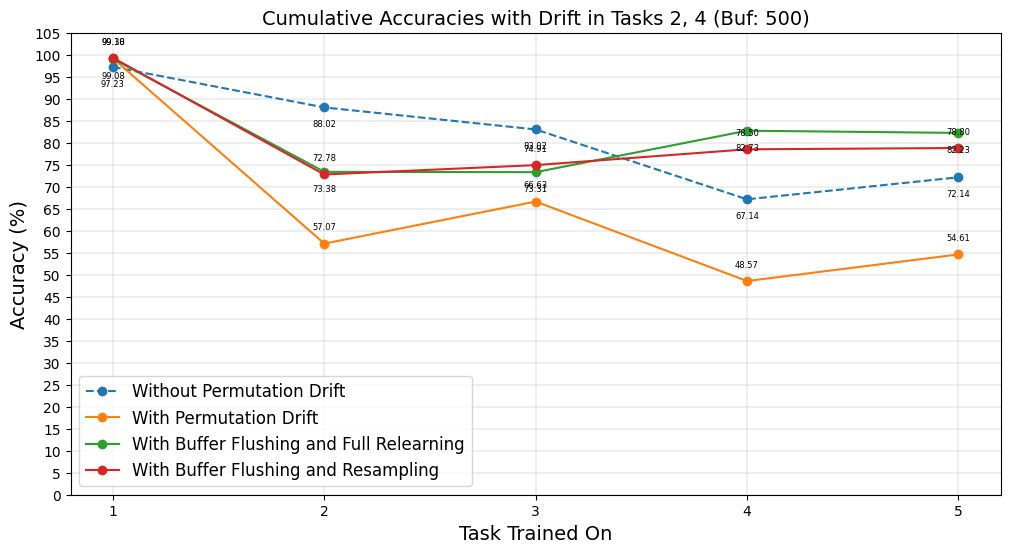

In [11]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 500)",
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [12]:
er_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er-buf-5000-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-24-25-16-14-55-seq-fashionmnist-er-buf-5000-drift-6-s-5-n-2-adaptation-0.json: 80.13
2: ./reimplementation-logs/03-24-25-16-15-26-seq-fashionmnist-er-buf-5000-drift-6-s-5-n-2-adaptation-0.json: 81.48
3: ./reimplementation-logs/03-24-25-16-15-58-seq-fashionmnist-er-buf-5000-drift-6-s-5-n-2-adaptation-0.json: 80.21
FAA: 80.61 ± 0.62
Avg. Forgetting: 15.29 ± 4.39


### Permutation Drift in Tasks 2, 4

In [13]:
er_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-19-14-24-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-2-adaptation-0.json: 59.13
2: ./reimplementation-logs/05-05-25-19-14-32-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-2-adaptation-0.json: 58.37
3: ./reimplementation-logs/05-05-25-19-15-18-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-2-adaptation-0.json: 58.87
FAA: 58.79 ± 0.32
Avg. Forgetting: 48.08 ± 0.78


### Permutation Drift in Tasks 2, 4 with Full Relearning

In [14]:
er_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-19-31-43-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json: 90.49
2: ./reimplementation-logs/05-05-25-19-31-32-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json: 90.39
3: ./reimplementation-logs/05-05-25-19-32-52-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json: 91.39
FAA: 90.76 ± 0.45
Avg. Forgetting: 7.89 ± 0.67


### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [15]:
er_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-19-21-21-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json: 92.39
2: ./reimplementation-logs/05-05-25-19-20-29-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json: 92.39
3: ./reimplementation-logs/05-05-25-19-21-07-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json: 92.65
FAA: 92.48 ± 0.12
Avg. Forgetting: 6.80 ± 1.23


### Cumulative Plots

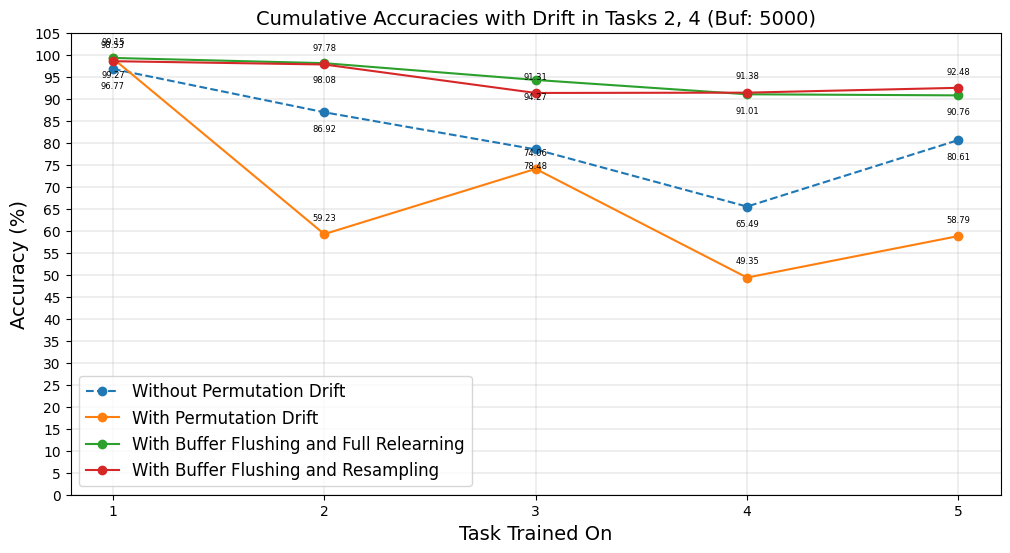

In [16]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 5000)",
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# ER-ACE

## Buffer 500

### Accuracy Without Drift

In [17]:
er_ace_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er_ace-buf-500-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-25-25-14-28-27-seq-fashionmnist-er_ace-buf-500-drift-6-s-5-n-2-adaptation-0.json: 68.54
2: ./reimplementation-logs/03-25-25-14-29-37-seq-fashionmnist-er_ace-buf-500-drift-6-s-5-n-2-adaptation-0.json: 62.34
3: ./reimplementation-logs/03-25-25-14-29-03-seq-fashionmnist-er_ace-buf-500-drift-6-s-5-n-2-adaptation-0.json: 70.60
FAA: 67.16 ± 3.51
Avg. Forgetting: 2.84 ± 2.79


### Permutation Drift in Tasks 2, 4

In [18]:
er_ace_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-19-45-35-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-2-adaptation-0.json: 64.83
2: ./reimplementation-logs/05-05-25-19-43-19-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-2-adaptation-0.json: 62.26
3: ./reimplementation-logs/05-05-25-19-43-50-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-2-adaptation-0.json: 62.29
FAA: 63.13 ± 1.20
Avg. Forgetting: 31.75 ± 1.17


### Permutation Drift in Tasks 2, 4 with Full Relearning

In [19]:
er_ace_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-19-52-09-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json: 89.05
2: ./reimplementation-logs/05-05-25-19-51-39-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json: 90.28
3: ./reimplementation-logs/05-05-25-19-51-52-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json: 89.62
FAA: 89.65 ± 0.50
Avg. Forgetting: 5.49 ± 0.44


### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [20]:
er_ace_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-20-12-17-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json: 84.85
2: ./reimplementation-logs/05-05-25-20-10-39-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json: 84.87
3: ./reimplementation-logs/05-05-25-20-11-07-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json: 85.60
FAA: 85.11 ± 0.35
Avg. Forgetting: 12.80 ± 0.25


### Cumulative Plots

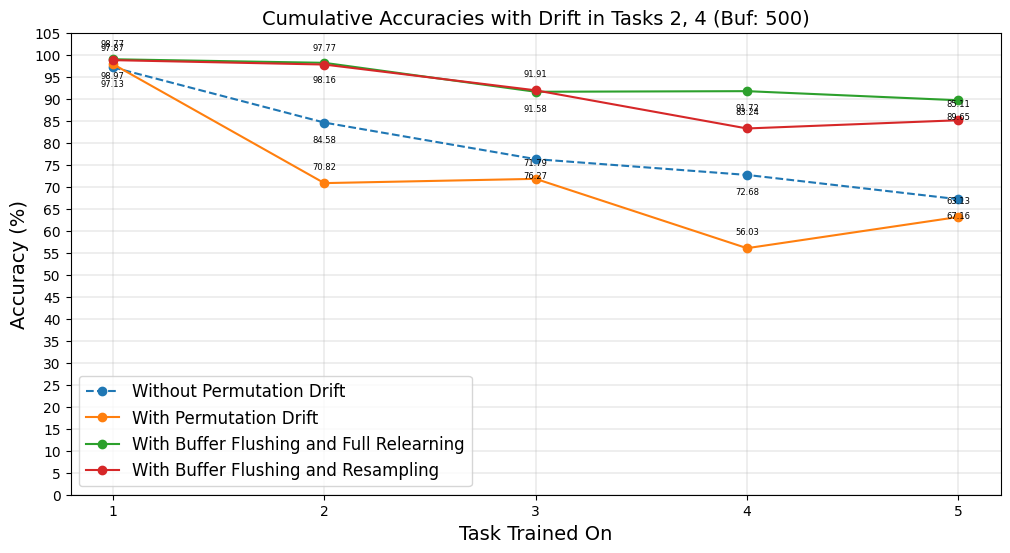

In [21]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 500)",
    [
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [22]:
er_ace_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er_ace-buf-5000-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-25-25-14-27-01-seq-fashionmnist-er_ace-buf-5000-drift-6-s-5-n-2-adaptation-0.json: 76.89
2: ./reimplementation-logs/03-25-25-14-26-00-seq-fashionmnist-er_ace-buf-5000-drift-6-s-5-n-2-adaptation-0.json: 69.66
3: ./reimplementation-logs/03-25-25-14-26-32-seq-fashionmnist-er_ace-buf-5000-drift-6-s-5-n-2-adaptation-0.json: 70.91
FAA: 72.49 ± 3.16
Avg. Forgetting: 1.50 ± 0.09


### Permutation Drift in Tasks 2, 4

In [23]:
er_ace_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-20-16-32-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-0.json: 57.01
2: ./reimplementation-logs/05-05-25-20-17-23-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-0.json: 58.95
3: ./reimplementation-logs/05-05-25-20-22-15-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-0.json: 59.57
FAA: 58.51 ± 1.09
Avg. Forgetting: 39.78 ± 2.31


### Permutation Drift in Tasks 2, 4 with Full Relearning

In [24]:
er_ace_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-20-30-13-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json: 90.15
2: ./reimplementation-logs/05-05-25-20-28-57-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json: 91.19
3: ./reimplementation-logs/05-05-25-20-29-31-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json: 89.86
FAA: 90.40 ± 0.57
Avg. Forgetting: 4.44 ± 0.27


### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [25]:
er_ace_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-20-36-02-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json: 93.23
2: ./reimplementation-logs/05-05-25-20-35-50-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json: 93.02
3: ./reimplementation-logs/05-05-25-20-36-16-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json: 93.26
FAA: 93.17 ± 0.11
Avg. Forgetting: 4.25 ± 0.42


### Cumulative Plots

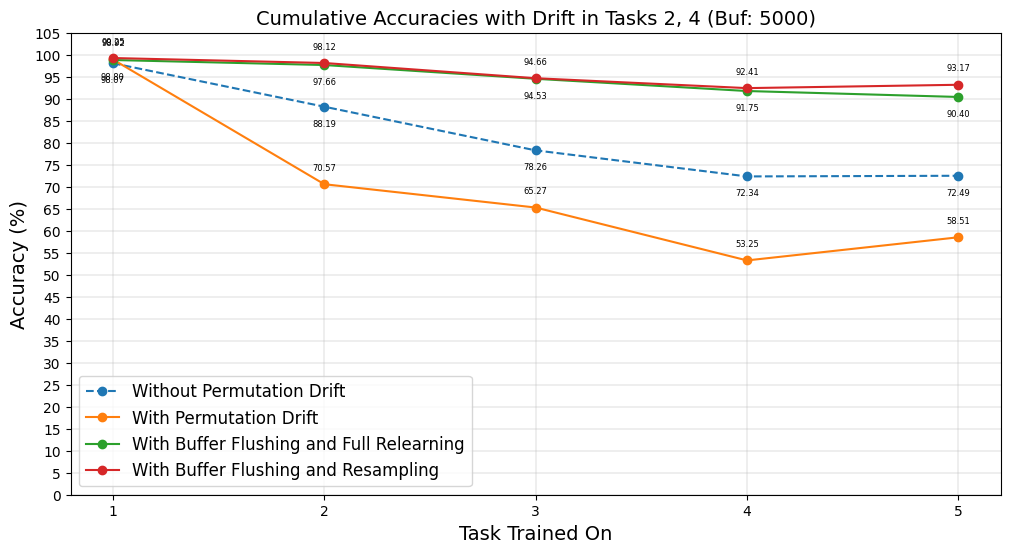

In [26]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 5000)",
    [
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# DER++

## Buffer 500

### Accuracy Without Drift

In [27]:
derpp_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-derpp-buf-500-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-12-51-35-seq-fashionmnist-derpp-buf-500-drift-6-s-5-n-2-adaptation-0.json: 82.02
2: ./reimplementation-logs/05-06-25-12-50-44-seq-fashionmnist-derpp-buf-500-drift-6-s-5-n-2-adaptation-0.json: 81.29
3: ./reimplementation-logs/05-06-25-12-49-38-seq-fashionmnist-derpp-buf-500-drift-6-s-5-n-2-adaptation-0.json: 81.75
FAA: 81.69 ± 0.30
Avg. Forgetting: 11.46 ± 0.67


### Permutation Drift in Tasks 2, 4

In [28]:
derpp_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-13-10-32-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-2-adaptation-0.json: 60.59
2: ./reimplementation-logs/05-06-25-12-56-14-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-2-adaptation-0.json: 61.54
3: ./reimplementation-logs/05-06-25-13-27-20-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-2-adaptation-0.json: 58.27
FAA: 60.13 ± 1.37
Avg. Forgetting: 40.40 ± 1.78


### Permutation Drift in Tasks 2, 4 with Full Relearning

In [29]:
derpp_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-13-37-03-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json: 74.96
2: ./reimplementation-logs/05-06-25-13-33-11-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json: 74.20
3: ./reimplementation-logs/05-06-25-13-33-21-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json: 74.00
FAA: 74.39 ± 0.41
Avg. Forgetting: 26.78 ± 0.57


### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [30]:
derpp_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-13-41-27-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json: 79.65
2: ./reimplementation-logs/05-06-25-13-41-21-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json: 79.92


3: ./reimplementation-logs/05-06-25-13-44-25-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json: 80.00
FAA: 79.86 ± 0.15
Avg. Forgetting: 18.93 ± 0.27


### Cumulative Plots

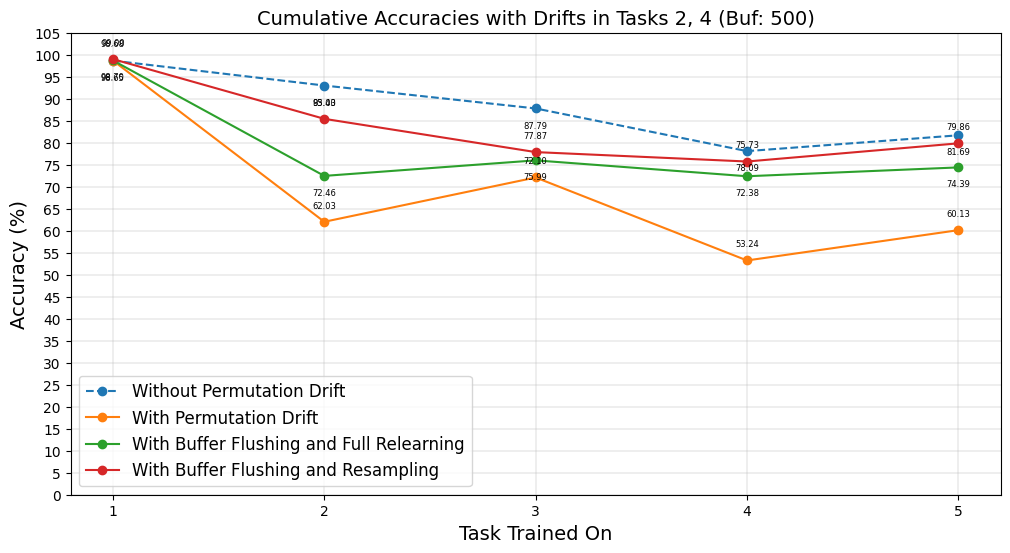

In [31]:
plot_cumulative_results(
    "Cumulative Accuracies with Drifts in Tasks 2, 4 (Buf: 500)",
    [
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [32]:
derpp_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-derpp-buf-5000-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-16-04-22-seq-fashionmnist-derpp-buf-5000-drift-6-s-5-n-2-adaptation-0.json: 84.60
2: ./reimplementation-logs/05-06-25-16-04-01-seq-fashionmnist-derpp-buf-5000-drift-6-s-5-n-2-adaptation-0.json: 83.12
3: ./reimplementation-logs/05-06-25-16-07-38-seq-fashionmnist-derpp-buf-5000-drift-6-s-5-n-2-adaptation-0.json: 86.26
FAA: 84.66 ± 1.28
Avg. Forgetting: 9.05 ± 1.43


### Permutation Drift in Tasks 2, 4

In [33]:
derpp_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-15-04-56-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-2-adaptation-0.json: 61.09
2: ./reimplementation-logs/05-06-25-15-03-30-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-2-adaptation-0.json: 62.99
3: ./reimplementation-logs/05-06-25-15-03-53-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-2-adaptation-0.json: 63.88
FAA: 62.65 ± 1.16
Avg. Forgetting: 37.55 ± 1.66


### Permutation Drift in Tasks 2, 4 with Full Relearning

In [34]:
derpp_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-15-17-49-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json: 91.21
2: ./reimplementation-logs/05-06-25-15-16-10-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json: 91.15
3: ./reimplementation-logs/05-06-25-15-16-21-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json: 91.33
FAA: 91.23 ± 0.07
Avg. Forgetting: 1.44 ± 1.07


### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [35]:
derpp_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-15-21-20-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json: 86.64
2: ./reimplementation-logs/05-06-25-15-24-24-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json: 88.42
3: ./reimplementation-logs/05-06-25-15-24-49-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json: 88.09
FAA: 87.72 ± 0.77
Avg. Forgetting: 10.98 ± 0.78


### Cumulative Plots

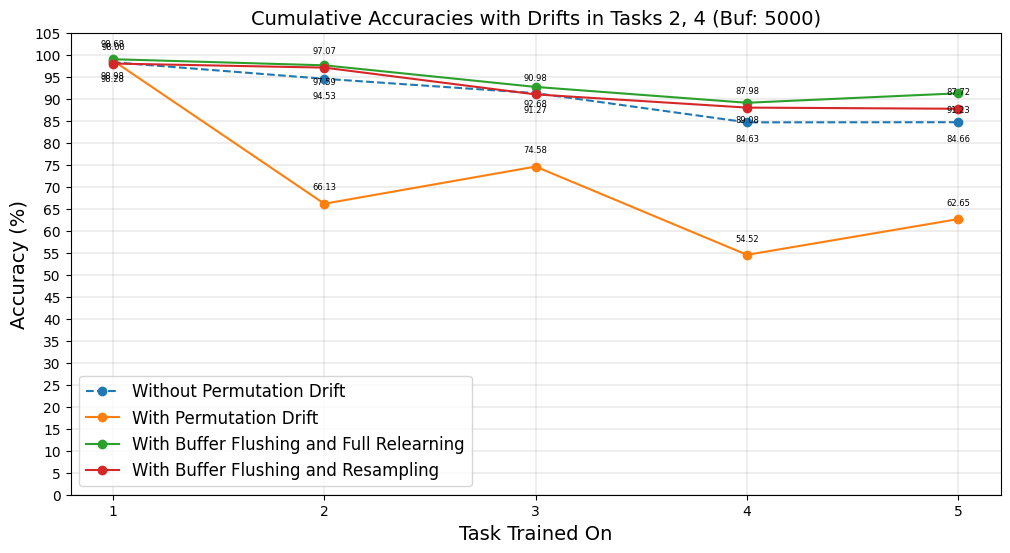

In [36]:
plot_cumulative_results(
    "Cumulative Accuracies with Drifts in Tasks 2, 4 (Buf: 5000)",
    [
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# SER

## Buffer 500

### Accuracy Without Drift

In [37]:
ser_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-ser-buf-500-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-17-38-08-seq-fashionmnist-ser-buf-500-drift-6-s-5-n-2-adaptation-0.json: 82.54
2: ./reimplementation-logs/05-06-25-17-38-23-seq-fashionmnist-ser-buf-500-drift-6-s-5-n-2-adaptation-0.json: 81.67
3: ./reimplementation-logs/05-06-25-17-37-42-seq-fashionmnist-ser-buf-500-drift-6-s-5-n-2-adaptation-0.json: 82.48
FAA: 82.23 ± 0.40
Avg. Forgetting: 11.82 ± 0.44


### Permutation Drift in Tasks 2, 4

In [38]:
ser_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-17-45-55-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-2-adaptation-0.json: 63.23
2: ./reimplementation-logs/05-06-25-17-50-33-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-2-adaptation-0.json: 64.91
3: ./reimplementation-logs/05-06-25-17-46-34-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-2-adaptation-0.json: 61.40
FAA: 63.18 ± 1.43
Avg. Forgetting: 34.82 ± 1.78


### Permutation Drift in Tasks 2, 4 with Full Relearning

In [39]:
ser_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-17-54-59-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-2-adaptation-1.json: 89.08
2: ./reimplementation-logs/05-06-25-17-55-29-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-2-adaptation-1.json: 89.30
3: ./reimplementation-logs/05-06-25-17-54-57-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-2-adaptation-1.json: 89.74
FAA: 89.37 ± 0.27
Avg. Forgetting: 3.40 ± 0.58


### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [40]:
ser_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-17-58-42-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-2-adaptation-2.json: 79.58
2: ./reimplementation-logs/05-06-25-17-58-53-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-2-adaptation-2.json: 81.03
3: ./reimplementation-logs/05-06-25-17-58-37-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-2-adaptation-2.json: 80.14
FAA: 80.25 ± 0.60
Avg. Forgetting: 16.68 ± 1.16


### Cumulative Plots

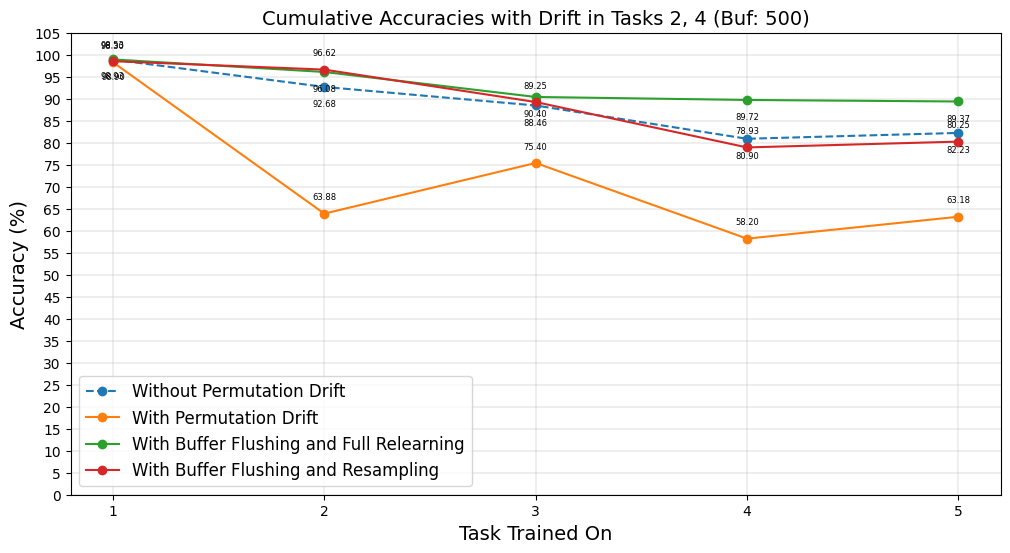

In [41]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 500)",
    [
        ser_500_accuracy_array_without_drift,
        ser_500_accuracy_array_with_drift,
        ser_500_accuracy_array_with_drift_full_relearning,
        ser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [42]:
ser_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-ser-buf-5000-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-18-03-56-seq-fashionmnist-ser-buf-5000-drift-6-s-5-n-2-adaptation-0.json: 86.63
2: ./reimplementation-logs/05-06-25-18-03-08-seq-fashionmnist-ser-buf-5000-drift-6-s-5-n-2-adaptation-0.json: 87.52
3: ./reimplementation-logs/05-06-25-18-03-35-seq-fashionmnist-ser-buf-5000-drift-6-s-5-n-2-adaptation-0.json: 86.01
FAA: 86.72 ± 0.62
Avg. Forgetting: 6.25 ± 0.91


### Permutation Drift in Tasks 2, 4

In [43]:
ser_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-18-09-10-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-2-adaptation-0.json: 64.64
2: ./reimplementation-logs/05-06-25-18-07-29-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-2-adaptation-0.json: 66.61
3: ./reimplementation-logs/05-06-25-18-07-51-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-2-adaptation-0.json: 67.33
FAA: 66.19 ± 1.14
Avg. Forgetting: 30.83 ± 2.22


### Permutation Drift in Tasks 2, 4 with Full Relearning

In [44]:
ser_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-18-15-24-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-2-adaptation-1.json: 90.99
2: ./reimplementation-logs/05-06-25-18-15-43-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-2-adaptation-1.json: 90.56
3: ./reimplementation-logs/05-06-25-18-15-01-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-2-adaptation-1.json: 90.44
FAA: 90.66 ± 0.24
Avg. Forgetting: 3.54 ± 1.26


### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [45]:
ser_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-19-32-45-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-2-adaptation-2.json: 91.41
2: ./reimplementation-logs/05-06-25-19-15-20-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-2-adaptation-2.json: 91.83
3: ./reimplementation-logs/05-06-25-19-33-16-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-2-adaptation-2.json: 91.28
FAA: 91.51 ± 0.23
Avg. Forgetting: 4.98 ± 0.81


### Cumulative Plots

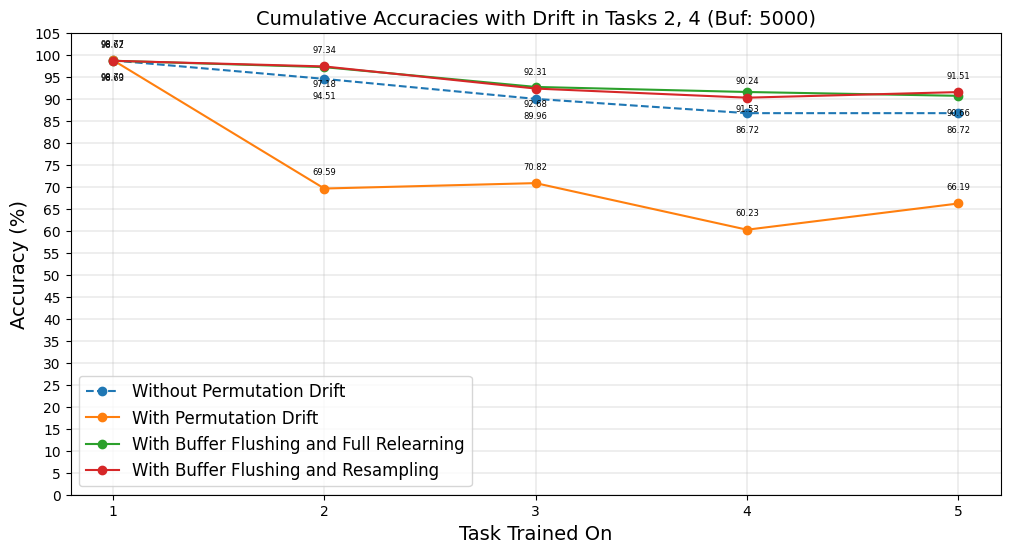

In [46]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 5000)",
    [
        ser_5000_accuracy_array_without_drift,
        ser_5000_accuracy_array_with_drift,
        ser_5000_accuracy_array_with_drift_full_relearning,
        ser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# CLSER

## Buffer 500

### Accuracy Without Drift

In [47]:
clser_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-clser-buf-500-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-15-16-53-seq-fashionmnist-clser-buf-500-drift-6-s-5-n-2-adaptation-0.json: 76.46
2: ./reimplementation-logs/05-05-25-15-18-02-seq-fashionmnist-clser-buf-500-drift-6-s-5-n-2-adaptation-0.json: 78.66
3: ./reimplementation-logs/05-05-25-15-17-09-seq-fashionmnist-clser-buf-500-drift-6-s-5-n-2-adaptation-0.json: 77.28
FAA: 77.47 ± 0.91
Avg. Forgetting: 21.71 ± 2.16


### Permutation Drift in Tasks 2, 4

In [48]:
clser_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-15-22-44-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json: 57.36
2: ./reimplementation-logs/05-05-25-15-23-24-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json: 59.04
3: ./reimplementation-logs/05-05-25-15-22-49-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json: 55.61
FAA: 57.34 ± 1.40
Avg. Forgetting: 46.85 ± 0.67


### Permutation Drift in Tasks 2, 4 with Full Relearning

In [49]:
clser_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-15-32-12-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json: 85.57
2: ./reimplementation-logs/05-05-25-15-31-41-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json: 86.00
3: ./reimplementation-logs/05-05-25-15-40-03-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json: 85.88
FAA: 85.82 ± 0.18
Avg. Forgetting: 12.93 ± 0.23


### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [50]:
clser_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-15-44-17-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json: 79.77
2: ./reimplementation-logs/05-05-25-15-43-24-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json: 79.30
3: ./reimplementation-logs/05-05-25-15-43-30-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json: 78.27
FAA: 79.11 ± 0.63
Avg. Forgetting: 21.28 ± 1.31


### Cumulative Plots

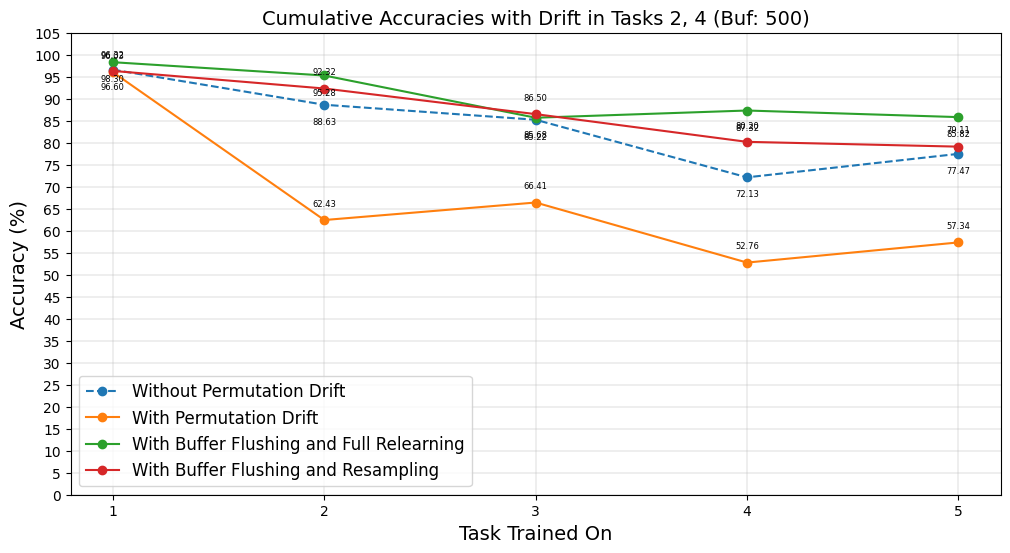

In [51]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 500)",
    [
        clser_500_accuracy_array_without_drift,
        clser_500_accuracy_array_with_drift,
        clser_500_accuracy_array_with_drift_full_relearning,
        clser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [52]:
clser_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-clser-buf-5000-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-15-50-52-seq-fashionmnist-clser-buf-5000-drift-6-s-5-n-2-adaptation-0.json: 82.50
2: ./reimplementation-logs/05-05-25-15-52-21-seq-fashionmnist-clser-buf-5000-drift-6-s-5-n-2-adaptation-0.json: 80.49
3: ./reimplementation-logs/05-05-25-15-50-24-seq-fashionmnist-clser-buf-5000-drift-6-s-5-n-2-adaptation-0.json: 79.73
FAA: 80.91 ± 1.17
Avg. Forgetting: 17.91 ± 1.39


### Permutation Drift in Tasks 2, 4

In [53]:
clser_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-16-06-25-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-2-adaptation-0.json: 61.33
2: ./reimplementation-logs/05-05-25-16-01-30-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-2-adaptation-0.json: 57.79
3: ./reimplementation-logs/05-05-25-16-00-10-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-2-adaptation-0.json: 60.28
FAA: 59.80 ± 1.48
Avg. Forgetting: 44.19 ± 1.91


### Permutation Drift in Tasks 2, 4 with Full Relearning

In [54]:
clser_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-16-25-08-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-2-adaptation-1.json: 84.20
2: ./reimplementation-logs/05-05-25-16-24-41-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-2-adaptation-1.json: 85.79
3: ./reimplementation-logs/05-05-25-16-27-14-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-2-adaptation-1.json: 86.46
FAA: 85.48 ± 0.95
Avg. Forgetting: 11.34 ± 0.56


### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [55]:
clser_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-16-43-42-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-2-adaptation-2.json: 79.93
2: ./reimplementation-logs/05-05-25-16-41-55-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-2-adaptation-2.json: 81.01
3: ./reimplementation-logs/05-05-25-16-41-39-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-2-adaptation-2.json: 80.54
FAA: 80.49 ± 0.44
Avg. Forgetting: 20.93 ± 0.99


### Cumulative Plots

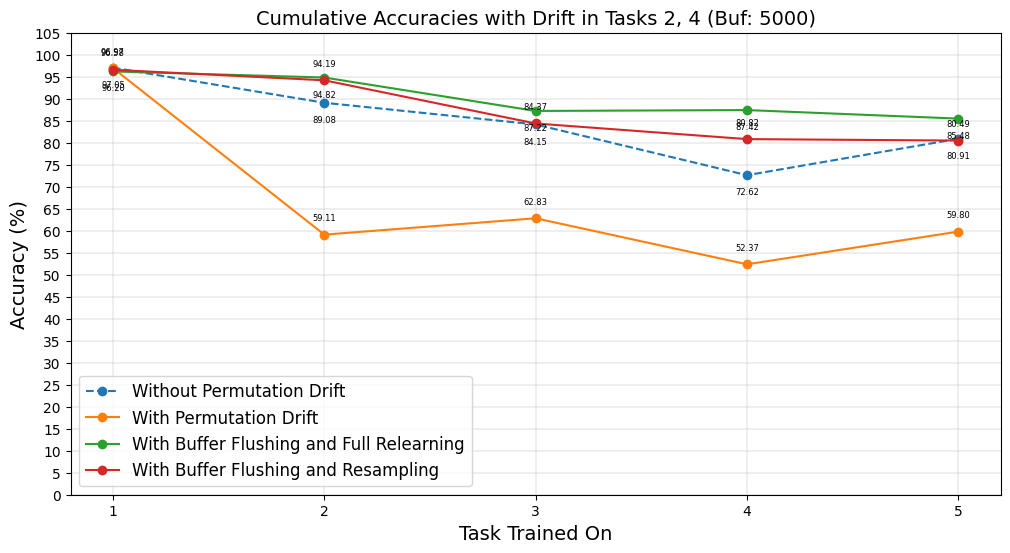

In [56]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 5000)",
    [
        clser_5000_accuracy_array_without_drift,
        clser_5000_accuracy_array_with_drift,
        clser_5000_accuracy_array_with_drift_full_relearning,
        clser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# Comparisons

## Buffer 500

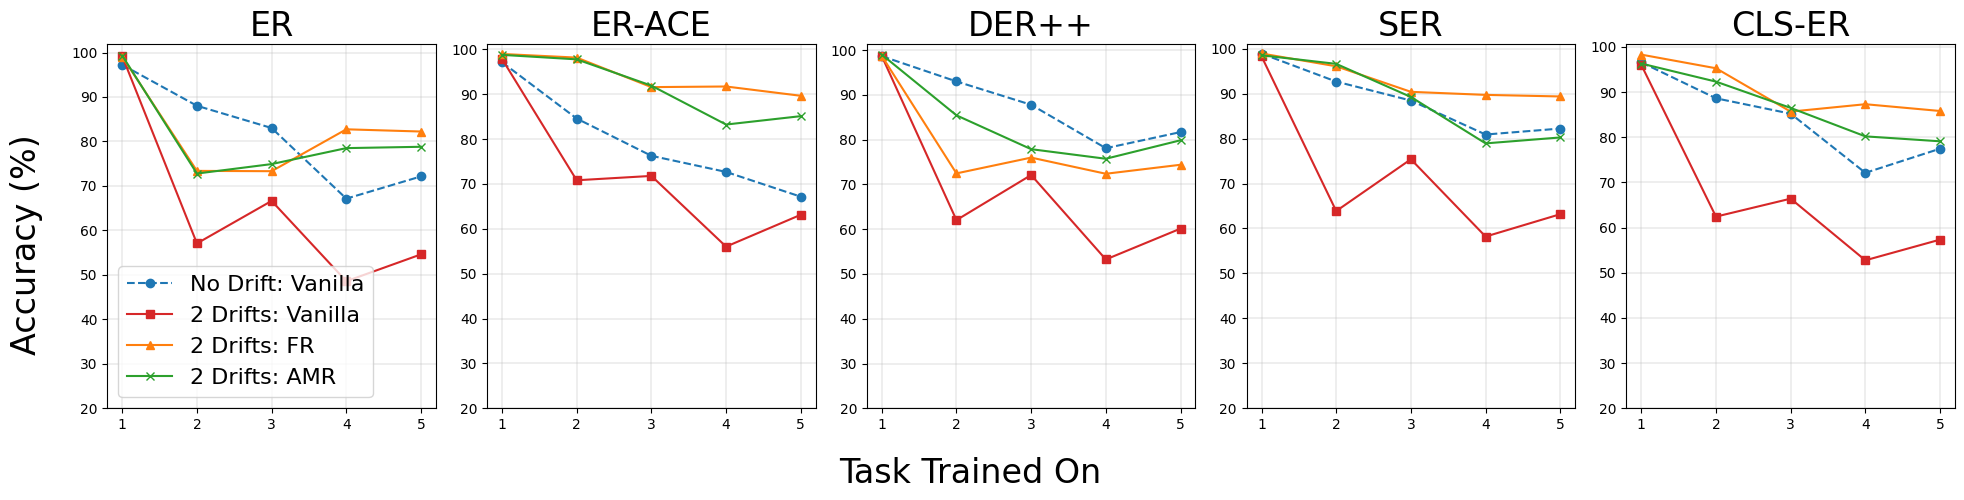

In [59]:
plot_cumulative_subplots(
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
        ser_500_accuracy_array_without_drift,
        ser_500_accuracy_array_with_drift,
        ser_500_accuracy_array_with_drift_full_relearning,
        ser_500_accuracy_array_with_drift_buffer_resampling,
        clser_500_accuracy_array_without_drift,
        clser_500_accuracy_array_with_drift,
        clser_500_accuracy_array_with_drift_full_relearning,
        clser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    ["ER", "ER-ACE", "DER++", "SER", "CLS-ER"],
    [
        "No Drift: Vanilla",
        "2 Drifts: Vanilla",
        "2 Drifts: FR",
        "2 Drifts: AMR",
    ],
    plot_filename="FashionMNIST_Buff_500_n_2.pdf",
)

## Buffer 5000

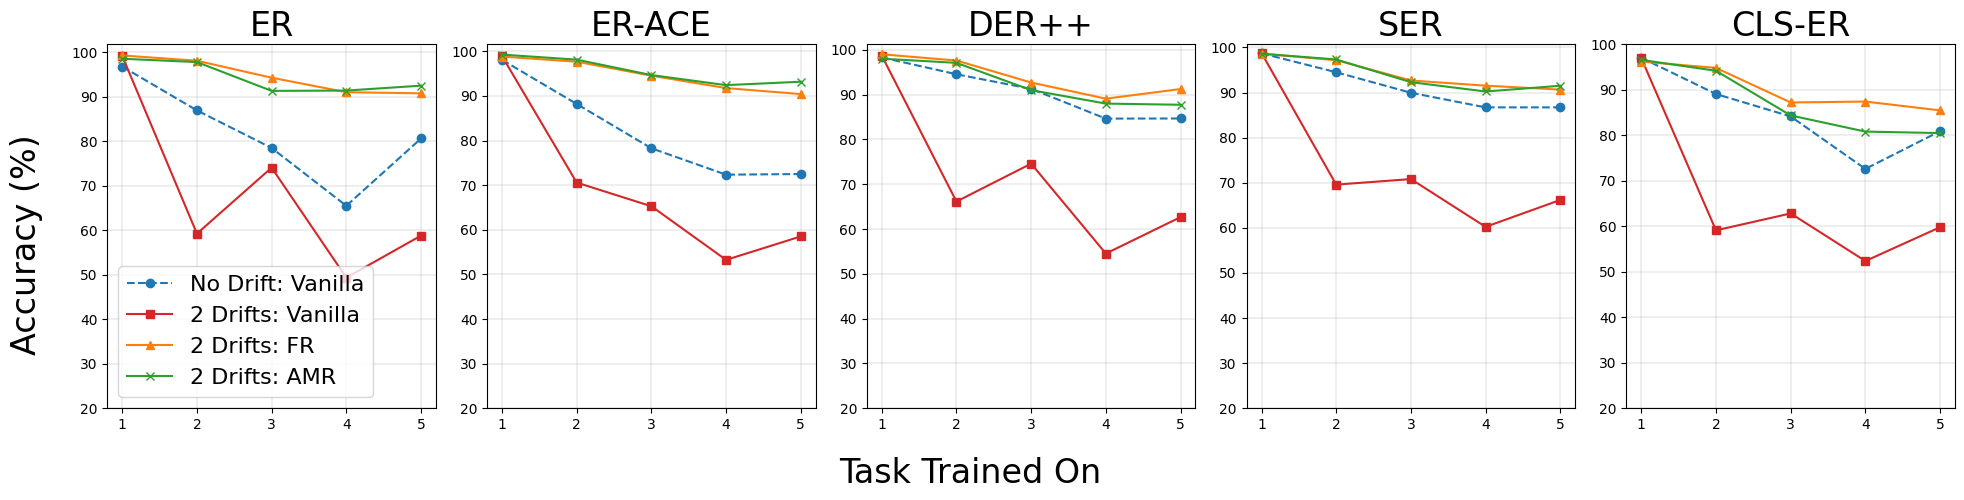

In [60]:
plot_cumulative_subplots(
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
        ser_5000_accuracy_array_without_drift,
        ser_5000_accuracy_array_with_drift,
        ser_5000_accuracy_array_with_drift_full_relearning,
        ser_5000_accuracy_array_with_drift_buffer_resampling,
        clser_5000_accuracy_array_without_drift,
        clser_5000_accuracy_array_with_drift,
        clser_5000_accuracy_array_with_drift_full_relearning,
        clser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    ["ER", "ER-ACE", "DER++", "SER", "CLS-ER"],
    [
        "No Drift: Vanilla",
        "2 Drifts: Vanilla",
        "2 Drifts: FR",
        "2 Drifts: AMR",
    ],
    plot_filename="FashionMNIST_Buff_5000_n_2.pdf",
)